In [1]:
using LinearAlgebra
using Plots

In [28]:
"""
    Izračuna spremembo stanja sistema po enem koraku po metodi Runge-Kutta četrtega reda.
    Vhod:
        x: trenutno stanje sistema
        der: odvod sistema
        h: časovna enota koraka
    Izhod:
        y: novo stanje sistema 
"""
function rungekutta_step(x,der,h)
    k1 = h*der(x)
    k2 = h*der(x+k1/2)
    k3 = h*der(x+k2/2)
    k4 = h*der(x+k3)
    return x + (k1 + 2k2 + 2k3 + k4)/6
end


step_rk (generic function with 2 methods)

In [64]:
"""
    Odvod glede na stanje sistema in mu, po enačbah. Za poenostavitev odstranimo Z koordinato.
"""

function der(x,mi)
    
    mi_ = 1-mi
    
    R = sqrt((x[1]+mi)^2+x[2]^2)
    r = sqrt((x[1]-mi_)^2+x[2]^2)
    
    (mi_/R^3) #-(mi_/R^3)(x[1]+mi)-(mi/r^3)(x[1]-mi_)
    
    return [
        x[3],
        x[4],
        x[1]+2x[4]-(mi_/R^3)*(x[1]+mi)-(mi/r^3)*(x[1]-mi_),
        x[2]-2x[3]-(mi_/R^3)*(x[2])-(mi/r^3)*(x[2]),
        ]
end


f (generic function with 1 method)

Najprej preizkusimo in vizualiziramo dve že znani orbiti, najdeni na internetu:

In [599]:
x =  [0.994, 0, 0, -2.00158510637908]
#x = [1.2, 0, 0, -1.049357510]                 #najbolj stabilna orbita
mi= 0.012277471

xs = [x[1]]
ys = [x[2]]

#t = 9
#n = 5000

t = 34
n = 100000

h = t/n

for i=1:n
    x = rungekutta_step(x,x->der(x,mi),h)
    #x = step_rk(x,f,mi,h)
    xs = vcat(xs,x[1])
    ys = vcat(ys,x[2])
end

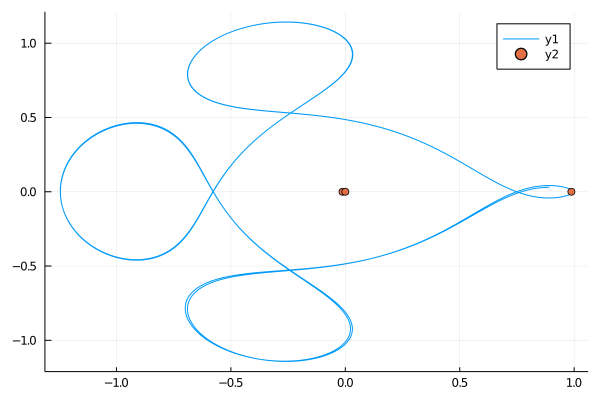

In [600]:
plot(xs,ys)#,xlim=(1-mi-0.01,1-mi+0.01),ylim=(-0.01,0.01))
scatter!([-mi,1-mi,0],[0,0,0])


┌ Info: Saved animation to 
│   fn = /media/juice/linux/College/nummat/nummat-2122/hw4/tmp.gif
└ @ Plots /home/juice/.julia/packages/Plots/uCh2y/src/animation.jl:104


Plots.AnimatedGif("/media/juice/linux/College/nummat/nummat-2122/hw4/tmp.gif")
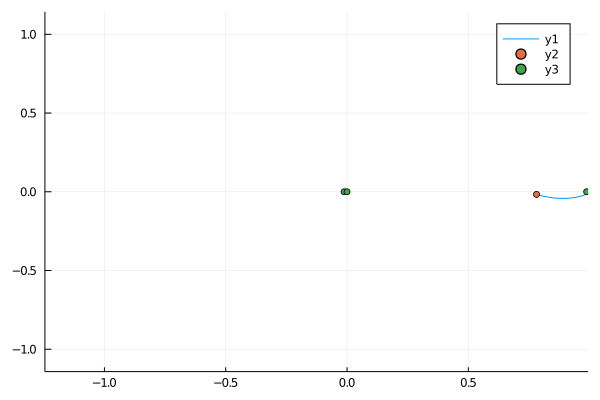

In [601]:
tn = floor(Int(n/100))

xl = (findmin(xs)[1],findmax(xs)[1])
yl = (findmin(ys)[1],findmax(ys)[1])

anim = @animate for i in 1:100
    plot(xs[1:tn*i],ys[1:tn*i],xlim=xl,ylim=yl)
    scatter!([xs[tn*i]],[ys[tn*i]])
    scatter!([-mi,1-mi,0],[0,0,0])
end
gif(anim,fps=15)

In [178]:
"""
    x1 in x2 sta dve vrednosti linearne funkcije ob časih 0 in 1. Izračuna, ob katerem času je funkcija 0.
"""
function presecisce(x1,x2)
    len = abs(x1-x2)
    ratio = abs(x1/len)
    return ratio
end

presecisce (generic function with 1 method)

Za računanje nove orbite, recimo da začnemo na položaju [-0.2,0], torej v orbiti zemlje, s hitrostjo pravokotno na orbito. Iščemo torej začetno hitrost, 
s katero zapustimo orbito zemlje, obidemo luno, in se vrnemo nazaj v začetni položaj. Torej, če gledamo koordinato y, želimo da je v drugi ničli sonda zopet v začetnem položaju.

In [395]:
"""
    Funkcija računa gibanje sonde in vrne položaj x, kjer y drugič prečka ničlo.
"""
function get_function(vy)
    x =  [-0.2, 0, 0, vy]
    mi= 0.012277471

    xs = [x[1]]
    ys = [x[2]]

    t = 5
    n = 50000

    h = t/n
    
    nicla = 0

    for i=1:n
        prev_x = x
        x = rungekutta_step(x,x->der(x,mi),h)
        #x = step_rk(x,f,mi,h)

        if prev_x[2]*x[2] < 0     #iščemo ničlo natančnejše
            
            nicla+=1
            
            if nicla==2

                ratio = h
                y = x

                ratio = presecisce(prev_x[2],y[2])*ratio        #izračunamo časovni korak, da pridemo do ničle, če bi bilo premikanje linearno

                for i=1:5
                    y = rungekutta_step(prev_x,x->der(x,mi),ratio)       #izračunamo dejansko stanje, če se premaknemo za izračunan korak
                    ratio = presecisce(prev_x[2],y[2])*ratio              #izračunamo nov časovni korak, in to iteriramo
                end

                display(y[1])
                #display(der([y[1],0,0,0],mi))
                #display(1-mi)

                #return der([y[1],0,0,0],mi)[3]
                return xs,ys,y[1]+0.2
            end

        end

        xs = vcat(xs,x[1])
        ys = vcat(ys,x[2])
    end
end

get_function

In [319]:
"""
    Funkcija za izkanje ničle prek sekantne metode.
    Vhod:
        f: funkcija, katere ničlo iščemo
        x1: prvi začetni približek
        x2: drugi začetni približek
        maxit: maksimalno število iteracij
        tol: toleranca
    Izhod:
        xs: x položaji, ki jih vrne zadnja iteracija
        ys: y položaji, ki jih vrne zadnja iteracija
        x: izračunan približek
        it: število iteracij
"""

function sekantna(f, x1, x2, maxit=100, tol = 1e-12)
      
    x = 0
    
    for i=1:maxit
        xs,ys,fx1 = f(x1)
        xs,ys,fx2 = f(x2)
        
        step = (fx2 * (x2-x1))/(fx2-fx1)
        
        step = clamp(step,-0.01,0.01)
        
        x = x2 - step

        x1 = x2
        x2 = x #0.9*x2+0.1*x
        
        #display(x)
        
        xs,ys,fx = f(x)
        
        display(fx)
        
        if abs(fx) < tol
            return xs,ys,x,i
        end
        
    end
    
    return xs,ys,x,maxit
        
end

sekantna (generic function with 3 methods)

Naš problem je občutljiv, zato moramo začetne pogoje izbrati previdno. Na roke najdemo dve začetni hitrosti, pri katerih sonda obide luno in se vrne približno nazaj do zemlje,
nato pa uporabimo sekantno metodo da najdemo točno vrednost.

In [396]:
xs,ys, res, it = sekantna(get_function,3.32,3.321)

-0.6015363879820632

-0.7174089453224289

-0.08798558334467457

0.11201441665532544

-0.7174089453224289

-0.08798558334467457

-0.22575023490092808

-0.025750234900928065

-0.08798558334467457

-0.22575023490092808

-0.20009413301376885

-9.413301376884342e-5

-0.22575023490092808

-0.20009413301376885

-0.1999992550358981

7.449641019063868e-7

-0.20009413301376885

-0.1999992550358981

-0.20000000001833967

-1.8339663121480498e-11

-0.1999992550358981

-0.20000000001833967

-0.19999999999978388

2.1613266731890235e-13

([-0.2, -0.1999998276415068, -0.19999931056687964, -0.19999844877867587, -0.19999724228115767, -0.19999569108029203, -0.19999379518375046, -0.19999155460090898, -0.19998896934284782, -0.19998603942235116  …  -0.19998344464115644, -0.1999866505564268, -0.1999895118207311, -0.19999202841992056, -0.19999420034155013, -0.19999602757487886, -0.19999751011087, -0.1999986479421913, -0.19999944106321518, -0.1999998894700188], [0.0, 0.0003317179327587554, 0.0006634353045840637, 0.0009951515545493837, 0.0013268661217419868, 0.0016585784452698615, 0.0019902879642686184, 0.0023219941179083944, 0.0026536963454007545, 0.002985394086005593  …  -0.0032510425383715045, -0.0029193488021315747, -0.0025876501299607817, -0.0022559470825555352, -0.0019242402206661009, -0.0015925301050897, -0.001260817296663608, -0.0009291023562582525, -0.000597385844770309, -0.00026566832311579594], 3.3171802624790576, 6)

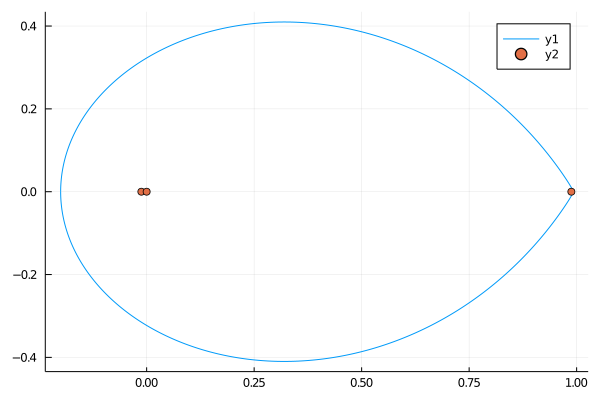

In [397]:
#prikažemo končno orbito, s samo enim obhodom
plot(xs,ys)
scatter!([-mi,1-mi,0],[0,0,0])

Poženemo rešitev še za dalj časa. Izgleda stabilna za 3 obhode, po katerih pa odleti iz orbite.

In [408]:
x =  [-0.2, 0, 0, 3.3171802624790576]
mi= 0.012277471

xs = [x[1]]
ys = [x[2]]

t = 9
n = 100000

h = t/n

for i=1:n
    x = rungekutta_step(x,x->der(x,mi),h)
    #x = step_rk(x,f,mi,h)
    xs = vcat(xs,x[1])
    ys = vcat(ys,x[2])
end

┌ Info: Saved animation to 
│   fn = /media/juice/linux/College/nummat/nummat-2122/hw4/tmp.gif
└ @ Plots /home/juice/.julia/packages/Plots/uCh2y/src/animation.jl:104


Plots.AnimatedGif("/media/juice/linux/College/nummat/nummat-2122/hw4/tmp.gif")
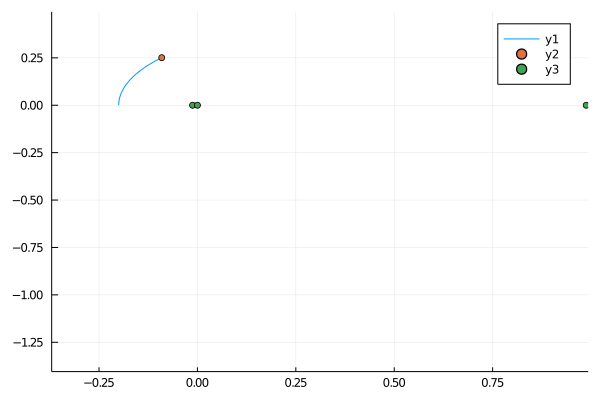

In [409]:
tn = floor(Int(n/100))

xl = (findmin(xs)[1],findmax(xs)[1])
yl = (findmin(ys)[1],findmax(ys)[1])

anim = @animate for i in 1:100
    plot(xs[1:tn*i],ys[1:tn*i],xlim=xl,ylim=yl)
    scatter!([xs[tn*i]],[ys[tn*i]])
    scatter!([-mi,1-mi,0],[0,0,0])
end
gif(anim,fps=15)